In [1]:
import pandas as pd
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.optim as optim
from pprint import pprint
from tqdm import tqdm


In [1]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

NameError: name 'torch' is not defined

<h1> DATA CLEANING AND PREPARATION <h1>

In [3]:
df = pd.read_csv('DataAnimals.csv')

<h3> Train Test Split <h3>

In [4]:
train_df, test_df = np.split(df.sample(frac = 1, random_state = 40),[int(.9*len(df))] )
print(len(train_df), len(test_df))
train_df = train_df.dropna(axis = 0)
train_df = train_df.reset_index(drop=True)
train_df.to_csv('train.csv',index=False)

test_df = test_df.dropna(axis=0)
test_df = test_df.reset_index(drop=True)
test_df.to_csv('test.csv',index=False)

197 22


In [5]:
# device = torch.device('cuda') if torch.cuda.is_available() else torch.cuda('cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cpu')

In [6]:
class AnimalDataset(Dataset): 
    def __init__(self,features,labels): 
        self.features = features
        self.labels = labels

    def __len__(self): 
        return len(self.labels)

    def __getitem__(self,idx): 
        return self.features[idx], self.labels[idx]

    

<h1> FIRST CLASSIFICATION: Comparison with Excel Perceptron <h1>

Features: hair, scales, feather, moist skin

Target: cold blooded (1) or warm blooded (0)

In [7]:
train_df = pd.read_csv('excel_train.csv')
test_df = pd.read_csv('excel_test.csv')

In [8]:
features = ['hair', 'scales', 'feather', 'moist skin']
labels = ['cold-blooded']

In [9]:
x_train = torch.from_numpy(train_df[features].to_numpy()).float()
y_train = torch.from_numpy(train_df[labels].to_numpy()).long()
x_test = torch.from_numpy(test_df[features].to_numpy()).float()
y_test = torch.from_numpy(train_df[labels].to_numpy()).long()

x_train.requires_grad_(True)

x_train = x_train.to(device)
y_train = y_train.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)


In [10]:
train_ds = AnimalDataset(x_train, y_train)

batch_size = 8
train_loader = DataLoader(train_ds, batch_size, shuffle = True)

In [11]:
class MLP(nn.Module): 
    def __init__(self, input_size, hidden_size, output_size): 
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size), 
            nn.LeakyReLU(), 
            nn.Linear(hidden_size, hidden_size), 
            nn.LeakyReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self,x): 
        return self.net(x)

    def test(self,X,Y): 
        pred = self.forward(X)
        target = Y

        with torch.no_grad(): 
            num_correct = 0
            for y_hat, y in zip(pred,target): 
                y_hat = y_hat.detach().cpu()
                y_hat = np.argsort(-y_hat)[0]
                y_hat = y_hat.to(device)

                if y_hat == y: 
                    num_correct += 1

            return num_correct*100/len(X)

In [12]:
model = MLP(len(features),256,2).to(device)
lr = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr = lr)
print(model)

MLP(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=256, out_features=2, bias=True)
  )
)


In [13]:
train_losses = []
accuracies = []

epochs = 100
for epoch in range(epochs+1): 
    model.train()
    optimizer.zero_grad()

    pred = model.forward(x_train)

    loss = criterion(pred.squeeze(),y_train.squeeze())
    train_losses.append(loss.item())

    loss.backward()

    optimizer.step()

    model.eval()

    accuracy = model.test(x_train,y_train)
    accuracies.append(accuracy)
    if epoch % 10 == 0: 
        print(f'Epoch: {epoch} | Train Loss: {loss.item():.6f} | Train Accuracy: {accuracy:.2f}%')



Epoch: 0 | Train Loss: 0.712545 | Train Accuracy: 45.18%
Epoch: 10 | Train Loss: 0.709312 | Train Accuracy: 45.18%
Epoch: 20 | Train Loss: 0.706163 | Train Accuracy: 45.69%
Epoch: 30 | Train Loss: 0.703103 | Train Accuracy: 45.69%
Epoch: 40 | Train Loss: 0.700102 | Train Accuracy: 45.69%
Epoch: 50 | Train Loss: 0.697187 | Train Accuracy: 45.69%
Epoch: 60 | Train Loss: 0.694352 | Train Accuracy: 45.69%
Epoch: 70 | Train Loss: 0.691587 | Train Accuracy: 45.69%
Epoch: 80 | Train Loss: 0.688881 | Train Accuracy: 44.16%
Epoch: 90 | Train Loss: 0.686231 | Train Accuracy: 44.16%
Epoch: 100 | Train Loss: 0.683638 | Train Accuracy: 44.16%


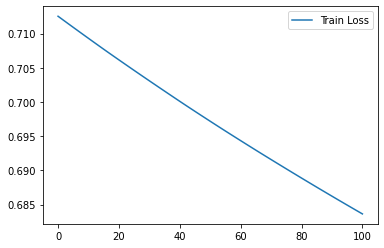

In [14]:
plt.plot(train_losses,label = 'Train Loss')
plt.legend()

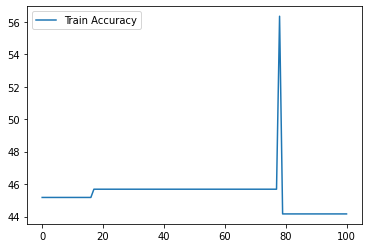

In [15]:
plt.plot(accuracies,label = 'Train Accuracy')
plt.legend()

SECOND CLASSIFICATION: FOR ALL FEATURES (except for cold blooded and warm blooded)

Target: cold blooded (1) or warm blooded (0)

In [16]:
train_df = pd.read_csv('excel_train.csv')
test_df = pd.read_csv('excel_test.csv')

In [17]:
features = ['hair', 'scales', 'feather', 'moist skin', 'sexual reproduction', 'asexual reproduction', 'vivipirous', 
'oviparous', 'hard-shelled eggs', 'soft eggs', 'breathe via skin', 'breathes via lungs', 'breathes via gills', 'herbivore', 
'carnivore', 'omnivore', 'mammary glands', 'claws', 'arms', 'wings', 'no legs', '2 legs', '4 legs', '6 legs', '>= 8 legs', 
'tentacles', 'toothed', 'fins', 'backbone', 'shell', 'vision', 'bill/beak', 'jaw', 'antennae', 'tail', 'venomous', 'aquatic', 
'terrestrial', 'symmetrical', 'asymmetrical']
labels = ['cold-blooded']

In [18]:
x_train = torch.from_numpy(train_df[features].to_numpy()).float()
y_train = torch.from_numpy(train_df[labels].to_numpy()).long()
x_test = torch.from_numpy(test_df[features].to_numpy()).float()
y_test = torch.from_numpy(train_df[labels].to_numpy()).long()

x_train.requires_grad_(True)

x_train = x_train.to(device)
y_train = y_train.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

<h1> PERCEPTRON <h1> 

In [19]:
class Perceptron(nn.Module): 
    def __init__(self,input_size,output_size): 
        super(Perceptron,self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size,output_size), 
            nn.LeakyReLU()
        )

    def forward(self,x): 
        return self.net(x)

    def test(self,X,Y): 
        pred = self.forward(X)
        target = Y

        with torch.no_grad(): 
            num_correct = 0

            for y_hat, y in zip(pred, target): 
                y_hat = y_hat.detach().cpu()
                y_hat = np.argsort(-y_hat)[0]
                y_hat = y_hat.to(device)

                if y_hat == y: 
                    num_correct += 1

                return num_correct*100/len(X)

In [20]:
model = Perceptron(len(features), 2).to(device)
lr = 0.005
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = lr)
print(model)

Perceptron(
  (net): Sequential(
    (0): Linear(in_features=40, out_features=2, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
)


In [21]:
train_losses = []
accuracies = []

epochs = 100
for epoch in range(epochs+1): 
    model.train()
    optimizer.zero_grad()

    pred = model.forward(x_train)

    loss = criterion(pred.squeeze(),y_train.squeeze())
    train_losses.append(loss.item())

    loss.backward()

    optimizer.step()

    model.eval()

    accuracy = model.test(x_train,y_train)
    accuracies.append(accuracy)
  
    if epoch % 10 == 0: 
        print(f'Epoch: {epoch} | Train Loss: {loss.item():.6f} | Train Accuracy: {accuracy:.2f}%')

Epoch: 0 | Train Loss: 0.656421 | Train Accuracy: 0.51%
Epoch: 10 | Train Loss: 0.650980 | Train Accuracy: 0.51%
Epoch: 20 | Train Loss: 0.645557 | Train Accuracy: 0.51%
Epoch: 30 | Train Loss: 0.640503 | Train Accuracy: 0.51%
Epoch: 40 | Train Loss: 0.635862 | Train Accuracy: 0.51%
Epoch: 50 | Train Loss: 0.631721 | Train Accuracy: 0.51%
Epoch: 60 | Train Loss: 0.628287 | Train Accuracy: 0.51%
Epoch: 70 | Train Loss: 0.625704 | Train Accuracy: 0.51%
Epoch: 80 | Train Loss: 0.623271 | Train Accuracy: 0.51%
Epoch: 90 | Train Loss: 0.620898 | Train Accuracy: 0.51%
Epoch: 100 | Train Loss: 0.618604 | Train Accuracy: 0.51%


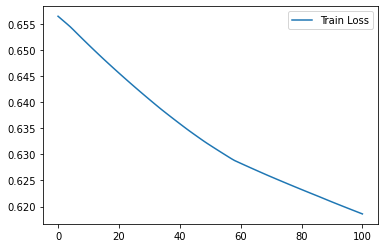

In [22]:
plt.plot(train_losses,label = 'Train Loss')
plt.legend()

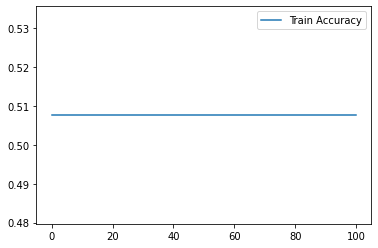

In [23]:
plt.plot(accuracies,label = 'Train Accuracy')
plt.legend()

In [24]:
model.eval()
accuracy = model.test(x_test,y_test)

print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 0.00%


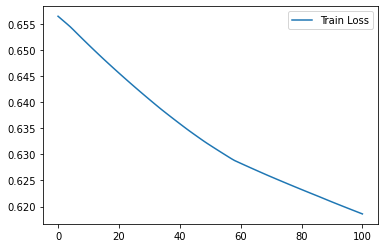

In [25]:
plt.plot(train_losses,label = 'Train Loss')
plt.legend()

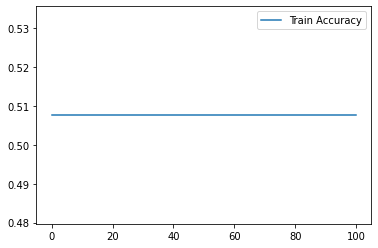

In [26]:
plt.plot(accuracies,label = 'Train Accuracy')
plt.legend()


<h1> MLP <h1>